# 📍 Extract Points

Herbie's `extract_points` accessor performs a nearest neighbor search to locate points of interest on a model grid and extracts the variable values at those points. It uses the BallTree algorithm implemented in **scikit-learn** with xarray's advanced index selection.

Note that Herbie uses the BallTree algorithm instead of the KDTree algorithm because BallTree allows us to use the haversine formula for the minimum distance weighting function, which is important when working with latitude and longitude coordinates.

> Extracting nearest-neighbor points from curvilinear grids has been a longstanding question for me. In November 2019 I asked about this question on [Stack Overflow (xarray select nearest lat/lon with multi-dimension coordinates)](https://stackoverflow.com/q/58758480/2383070) and suggested a solution. This question is apparently one many people have had given the 28k views in four years. I've iterated over different solutions. In the deprecated `nearest_points` method in Herbie, I used [MetPy: assign_y_x](https://unidata.github.io/MetPy/latest/tutorials/xarray_tutorial.html?highlight=assign_y_x) then transformed the latitude and longitude points to the map coordinates, and then extracted the nearest neighbor points. That didn't scale well when you wanted many points. Using the BallTree algorithm now implemented in Herbie's `extract_points` is the most scalable solution I've implemented so far, and has the benefit of the new capability computing the inverse-distance weighted mean of the four grid points nearest your points of interest.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import herbie  # noqa: F401

## A Very Simple Demonstration

Let's start with a very simple demonstration to show how extracting nearest points from a grid works.

Let's make a 3x3 xarray Dataset with latitude/longitude coodinates and then extract data nearest two points of interest.

Oh, and you'll need to `import herbie` to use the custom accessor.


In [2]:
# Create a 3x3 xarray dataset
ds = xr.Dataset(
    {"a": (["latitude", "longitude"], [[0, 1, 2], [0, 1, 0], [0, 0, 0]])},
    coords={
        "latitude": (["latitude"], [44, 45, 46]),
        "longitude": (["longitude"], [-99, -100, -101]),
    },
)
ds

<xarray.Dataset> Size: 120B
Dimensions:    (latitude: 3, longitude: 3)
Coordinates:
  * latitude   (latitude) int64 24B 44 45 46
  * longitude  (longitude) int64 24B -99 -100 -101
Data variables:
    a          (latitude, longitude) int64 72B 0 1 2 0 1 0 0 0 0

In [3]:
# We want to extract data closest to two points
points = pd.DataFrame(
    {
        "longitude": [-100.25, -99.4],
        "latitude": [44.25, 45.4],
    }
)
points

,longitude,latitude
0,-100.25,44.25
1,-99.40,45.40


Now we can extract those points with the custom Herbie xarray accessor.

> Note `method='nearest'` is the default behavior.


In [4]:
# Extract the value nearest the requested points
matched = ds.herbie.extract_points(points, method="nearest")
matched

<xarray.Dataset> Size: 96B
Dimensions:              (point: 2)
Coordinates:
    latitude             (point) int64 16B 44 45
    longitude            (point) int64 16B -100 -99
    point_grid_distance  (point) float64 16B 34.22 54.41
    point_longitude      (point) float64 16B -100.2 -99.4
    point_latitude       (point) float64 16B 44.25 45.4
Dimensions without coordinates: point
Data variables:
    a                    (point) int64 16B 1 0

Alternatively, we can get the inverse-distance weighted mean of the 4 nearest points. This takes 2-4x as long as the simple nearest neighbor, but is still fast.


In [5]:
# Distance weighted mean
matched_w = ds.herbie.extract_points(points, method="weighted")
matched_w

<xarray.Dataset> Size: 240B
Dimensions:              (point: 2, k: 4)
Coordinates:
    point_longitude      (point) float64 16B -100.2 -99.4
    point_latitude       (point) float64 16B 44.25 45.4
    latitude             (k, point) int64 64B 44 45 44 45 45 46 45 46
    longitude            (k, point) int64 64B -100 -99 -101 ... -99 -101 -100
    point_grid_distance  (k, point) float64 64B 34.22 54.41 66.0 ... 102.4 81.38
Dimensions without coordinates: point, k
Data variables:
    a                    (point) float64 16B 1.082 0.2588

That's a lot of info to digest. I'll plot it for you so you can see what was done...


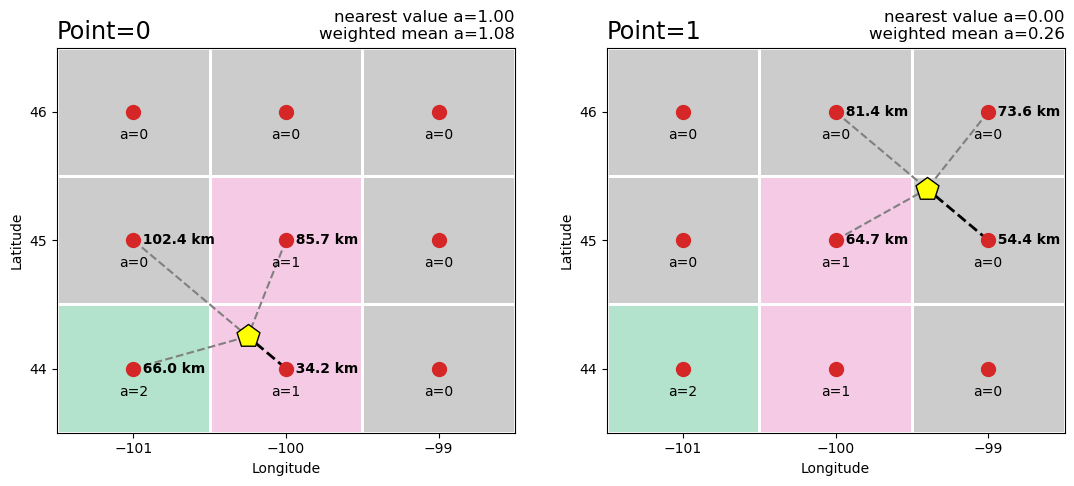

In [6]:
fig, axes = plt.subplots(1, 2, figsize=[13, 5])
for p, ax in zip(matched_w.point, axes):
    zz = matched.sel(point=p)

    # Plot grid
    ax.pcolormesh(
        ds.longitude, ds.latitude, ds.a, edgecolor="1", lw=1, cmap="Pastel2_r"
    )
    x, y = np.meshgrid(ds.longitude, ds.latitude)
    x = x.flatten()
    y = y.flatten()
    ax.scatter(x, y, facecolor="tab:red", edgecolor="tab:red", s=100, zorder=100)

    # Plot requested point
    ax.scatter(
        zz.point_longitude,
        zz.point_latitude,
        color="yellow",
        ec="k",
        marker="p",
        s=300,
        zorder=100,
    )
    for i in ds.latitude:
        for j in ds.longitude:
            z = ds.sel(latitude=i, longitude=j)
            ax.text(j, i, f"\na={z.a.item()}", ha="center", va="top")

    # Plot path to nearest point and distance
    # for i, j in zip(x, y):
    #    ax.plot([i, point.longitude.values[0]], [j, point.latitude.values[0]])
    for i in matched_w.k:
        if i == 0:
            kwargs = dict(lw=2, color="k", ls="--")
        else:
            kwargs = dict(color=".5", ls="--")
        z = matched_w.sel(k=i, point=p)
        ax.plot(
            [z.longitude, z.point_longitude], [z.latitude, z.point_latitude], **kwargs
        )
        ax.text(
            z.longitude,
            z.latitude,
            f"  {z.point_grid_distance.item():.1f} km",
            va="center",
            fontweight="bold",
        )
    ax.set_xticks(ds.longitude)
    ax.set_yticks(ds.latitude)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.set_title(f"Point={p.item()}", loc="left", fontsize="xx-large")
    ax.set_title(
        f"nearest value a={zz.a.item():.2f}\nweighted mean a={z.a.item():.2f}",
        loc="right",
    )

Summary: From a simple 2D DataSet with latitude and longitude coordinates, we were able to get the nearest value for two points of interest. We were also able to compute the inverse-distance weighted mean value from the four grids nearest our point of interest.


## Extract points from HRRR data

The above is nice, but you might say, "Yeah, but you can already select data from a grid using [xarray advanced selection](https://docs.xarray.dev/en/stable/user-guide/indexing.html#more-advanced-indexing)." That is true, but it does not work for models with curvilienar grids, like the HRRR model. That is why the BallTree algorithm is needed here to identify the grids nearest a point of interest.

Here is a demonstration using real HRRR data.


In [2]:
from herbie import Herbie

H = Herbie("2024-03-01", model="hrrr")
ds = H.xarray(":(?:TMP|DPT):2 m")
ds

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


<xarray.Dataset> Size: 46MB
Dimensions:              (y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (y, x) float64 15MB 21.14 21.15 21.15 ... 47.85 47.84
    longitude            (y, x) float64 15MB 237.3 237.3 237.3 ... 299.0 299.1
    valid_time           datetime64[ns] 8B 2024-03-01
Dimensions without coordinates: y, x
Data variables:
    t2m                  (y, x) float32 8MB 292.5 292.5 292.4 ... 266.8 266.8
    d2m                  (y, x) float32 8MB 287.3 287.2 287.2 ... 262.2 262.2
    gribfile_projection  object 8B None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240301/subset_e0ef89f...
    searchString:            :(?:TMP|DPT):2 m

Let's extract the data from the same two points we used earlier, but this time I will give the two point station id names


In [8]:
points = pd.DataFrame(
    {
        "latitude": [44.25, 45.4],
        "longitude": [-100.25, -99.4],
        "stid": ["apple", "orange"],
    }
)
points

,latitude,longitude,stid
0,44.25,-100.25,apple
1,45.40,-99.40,orange


In [9]:
matched = ds.herbie.extract_points(points)
matched

<xarray.Dataset> Size: 144B
Dimensions:              (point: 2)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (point) float64 16B 44.26 45.4
    longitude            (point) float64 16B 259.8 260.6
    valid_time           datetime64[ns] 8B 2024-03-01
    point_grid_distance  (point) float64 16B 1.103 1.054
    point_latitude       (point) float64 16B 44.25 45.4
    point_longitude      (point) float64 16B -100.2 -99.4
    point_stid           (point) object 16B 'apple' 'orange'
Dimensions without coordinates: point
Data variables:
    t2m                  (point) float32 8B 288.0 283.6
    d2m                  (point) float32 8B 269.4 271.4
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240301/subset_e0ef89f...
    searchString:            :(?:TMP|DPT):2 m

I will use the `point_stid` coordinate as my dimension


In [10]:
matched = matched.swap_dims({"point": "point_stid"})
matched

<xarray.Dataset> Size: 144B
Dimensions:              (point_stid: 2)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-01
    step                 timedelta64[ns] 8B 00:00:00
    heightAboveGround    float64 8B 2.0
    latitude             (point_stid) float64 16B 44.26 45.4
    longitude            (point_stid) float64 16B 259.8 260.6
    valid_time           datetime64[ns] 8B 2024-03-01
    point_grid_distance  (point_stid) float64 16B 1.103 1.054
    point_latitude       (point_stid) float64 16B 44.25 45.4
    point_longitude      (point_stid) float64 16B -100.2 -99.4
  * point_stid           (point_stid) object 16B 'apple' 'orange'
Data variables:
    t2m                  (point_stid) float32 8B 288.0 283.6
    d2m                  (point_stid) float32 8B 269.4 271.4
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240301/subset_e0ef89f...
    searchString:            :(?:TMP|DPT):2 m

<GeoAxes: >

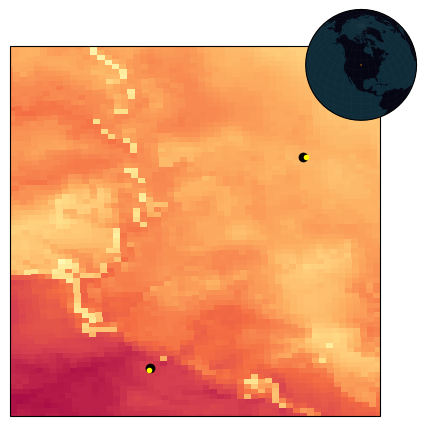

In [11]:
from toolbox import EasyMap, pc, ccrs

ax = EasyMap().ax
ax.pcolormesh(ds.longitude, ds.latitude, ds.t2m, cmap="Spectral_r", vmax=290, vmin=270)

for i in matched.point_stid:
    z = matched.sel(point_stid=i)
    ax.scatter(z.longitude, z.latitude, color="k")
    ax.scatter(z.point_longitude, z.point_latitude, color="yellow", marker=".")

ax.set_extent([-101, -99, 44, 46])
ax.EasyMap.INSET_GLOBE()

## Extract Point Sounding

If you want a "sounding" at a single point, you will need to get the GRIB data for all the model layers of interest (yes, that's a lot of data), then extract the point.


In [67]:
# TODO: Get some real sounding data using SounderPy and plot agains model data

In [75]:
H = Herbie("2024-03-28 00:00", model="hrrr", product="prs")
ds = H.xarray("(?:DPT|TMP):[0-9]* mb", remove_grib=False)

# Get HRRR sounding at Salt Lake City
slc = ds.herbie.extract_points(
    pd.DataFrame({"latitude": [40.76], "longitude": [-111.876183]})
)
slc

✅ Found ┊ model=hrrr ┊ product=prs ┊ 2024-Mar-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


<xarray.Dataset> Size: 688B
Dimensions:              (isobaricInhPa: 39, point: 1)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-28
    step                 timedelta64[ns] 8B 00:00:00
  * isobaricInhPa        (isobaricInhPa) float64 312B 1e+03 975.0 ... 75.0 50.0
    latitude             (point) float64 8B 40.75
    longitude            (point) float64 8B 248.1
    valid_time           datetime64[ns] 8B 2024-03-28
    point_grid_distance  (point) float64 8B 1.193
    point_latitude       (point) float64 8B 40.76
    point_longitude      (point) float64 8B -111.9
Dimensions without coordinates: point
Data variables:
    t                    (isobaricInhPa, point) float32 156B ...
    dpt                  (isobaricInhPa, point) float32 156B ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 prs
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240328/subset_0befd2f...
    searchString:            (?:DPT|TMP):[0-9]* mb

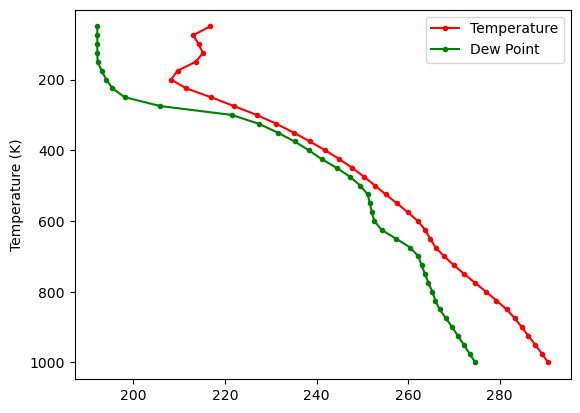

In [76]:
# TODO: plot data on a sounding using MetPy

ax = plt.gca()
ax.plot(slc.t, slc.isobaricInhPa, color="red", marker=".", label="Temperature")
ax.plot(slc.dpt, slc.isobaricInhPa, color="green", marker=".", label="Dew Point")
ax.invert_yaxis()
ax.set_ylabel("Level (hPa)")
ax.set_ylabel("Temperature (K)")
ax.legend()

## Extract Point Timeseries


In [82]:
# TODO: Could demonstrate using FastHerbie here

i = []
for date in pd.date_range("2024-01-01", periods=12, freq="1h"):
    ds = Herbie(date).xarray("TMP:2 m")
    i.append(
        ds.herbie.extract_points(
            pd.DataFrame({"latitude": [40.76], "longitude": [-111.876183]})
        )
    )
slc_ts = xr.concat(i, dim="valid_time")

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 01:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 02:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 03:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 04:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 05:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 07:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 08:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 09:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Jan-01 10:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr 

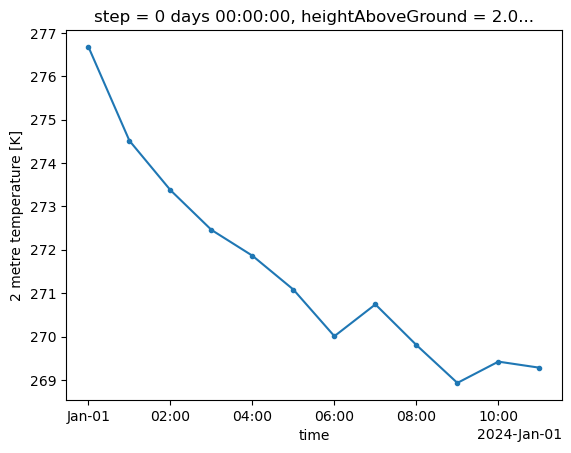

In [88]:
slc_ts.t2m.plot(x="valid_time", marker=".")

## Benchmark

Let's see how well `extract_points` works for many points...


In [3]:
H = Herbie("2024-03-28 00:00", model="hrrr")
ds = H.xarray("TMP:[5,6,7,8,9][0,5]0 mb", remove_grib=False)
ds

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2024-Mar-28 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


<xarray.Dataset> Size: 53MB
Dimensions:              (isobaricInhPa: 3, y: 1059, x: 1799)
Coordinates:
    time                 datetime64[ns] 8B 2024-03-28
    step                 timedelta64[ns] 8B 00:00:00
  * isobaricInhPa        (isobaricInhPa) float64 24B 850.0 700.0 500.0
    latitude             (y, x) float64 15MB ...
    longitude            (y, x) float64 15MB ...
    valid_time           datetime64[ns] 8B ...
Dimensions without coordinates: y, x
Data variables:
    t                    (isobaricInhPa, y, x) float32 23MB ...
    gribfile_projection  object 8B None
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    model:                   hrrr
    product:                 sfc
    description:             High-Resolution Rapid Refresh - CONUS
    remote_grib:             https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr....
    local_grib:              /home/blaylock/data/hrrr/20240328/subset_0beff0f...
    searchString:            TMP:[5,6,7,8,9][0,5]0 mb

Using the model's own grid, I will generate 100 random samples to extract.


In [4]:
def generate_random_string(len=8):
    """Generate a random string."""
    import random
    import string

    return "".join(random.choices(string.ascii_letters + string.digits, k=len))


n = 100
points_self = (
    ds[["latitude", "longitude"]]
    .to_dataframe()[["latitude", "longitude"]]
    .sample(n)
    .reset_index(drop=True)
)
points_self["stid"] = [generate_random_string() for _ in range(n)]
points_self

,latitude,longitude,stid
0,29.229199,286.389977,4IXWtece
1,51.259530,247.058138,8C1gaxOG
2,22.027845,285.775958,5Wjs0Cyr
3,38.833866,292.129745,g2mGG4xo
4,44.804355,264.760887,bZH1JxAV
...,...,...,...
95,48.789354,244.135644,lCnRexom
96,32.537700,268.068676,4uZRAUPu
97,24.432045,274.565557,jdyyoW1T
98,51.964908,259.857605,p0LuzI0R


In [5]:
%%time
y1 = ds.herbie.extract_points(points_self)

CPU times: user 108 ms, sys: 139 ms, total: 247 ms
Wall time: 246 ms


In [6]:
%%time
y2 = ds.herbie.extract_points(points_self, method="weighted")

CPU times: user 838 ms, sys: 209 ms, total: 1.05 s
Wall time: 1.04 s


In [7]:
%%time
# Try the deprecated `nearest_points` method which used MetPy
y3 = ds.herbie.nearest_points(points_self)

<timed exec>:2: DeprecationWarning: The accessor `ds.herbie.nearest_points` is deprecated in favor of the `ds.herbie.extract_points` which uses the BallTree algorithm instead.
/home/blaylock/GITHUB/Herbie/herbie/accessors.py:515: UserWarning: More than one time coordinate present for variable  "gribfile_projection".
  ds = ds.metpy.parse_cf()
/home/blaylock/GITHUB/Herbie/herbie/accessors.py:519: UserWarning: More than one time coordinate present for variable  "t".
  ds = ds.metpy.assign_y_x()
/home/blaylock/GITHUB/Herbie/herbie/accessors.py:519: UserWarning: More than one time coordinate present for variable  "gribfile_projection".
  ds = ds.metpy.assign_y_x()


CPU times: user 625 ms, sys: 21.1 ms, total: 646 ms
Wall time: 644 ms


In [12]:
all(y1.latitude == y3.latitude), all(y1.longitude == y3.longitude)

(True, True)

<GeoAxes: >

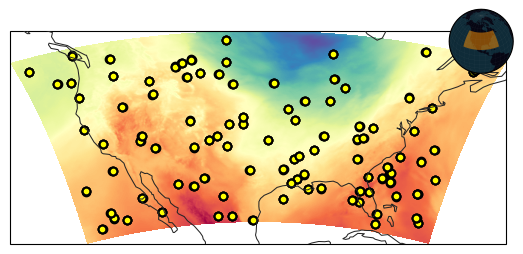

In [16]:
ax = EasyMap().ax
ax.pcolormesh(
    ds.longitude,
    ds.latitude,
    ds.isel(isobaricInhPa=0).t,
    cmap="Spectral_r",
)

for i in y1.point:
    z = y1.sel(point=i)
    ax.scatter(z.longitude, z.latitude, color="k")
    ax.scatter(z.point_longitude, z.point_latitude, color="yellow", marker=".")

ax.EasyMap.INSET_GLOBE()

Not bad. Less than half a second to extract 100 points from the HRRR grid.

Now let's try _even more_...


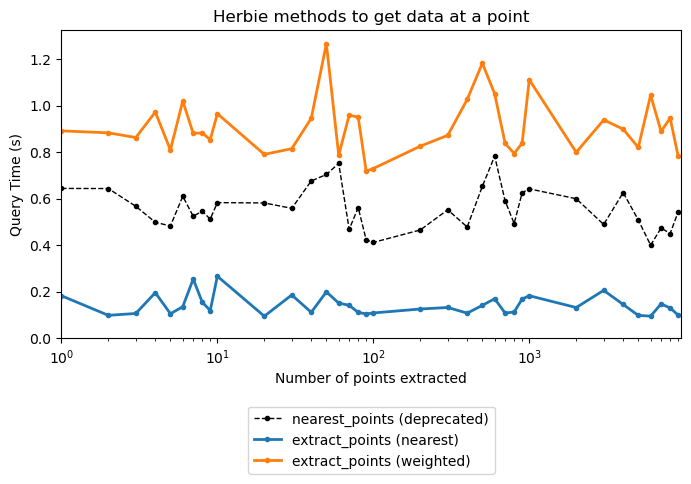

In [53]:
import warnings

n_samples = (
    [1, 2, 3, 4, 5, 6, 7, 8, 9]
    + list(range(10, 100, 10))
    + list(range(100, 1000, 100))
    + list(range(1000, 10000, 1000))
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Timers for nearest_points (deprecated)
    times_np = []
    samples_np = []

    # Timers for extract_points method='nearest'
    times_ep = []
    samples_ep = []

    # Timers for extract_points method='weighted'
    times_w = []
    samples_w = []

    for s in n_samples:
        samples_np.append(s)
        timer = pd.Timestamp("now")
        y1 = ds.herbie.nearest_points(points_self)
        times_np.append((pd.Timestamp("now") - timer).total_seconds())

        samples_ep.append(s)
        timer = pd.Timestamp("now")
        y1 = ds.herbie.extract_points(points_self, method="nearest")
        times_ep.append((pd.Timestamp("now") - timer).total_seconds())

        samples_w.append(s)
        timer = pd.Timestamp("now")
        y1 = ds.herbie.extract_points(points_self, method="weighted")
        times_w.append((pd.Timestamp("now") - timer).total_seconds())


plt.figure(figsize=[8, 4])
plt.plot(
    samples_np,
    times_np,
    marker=".",
    lw=1,
    color="k",
    ls="--",
    label="nearest_points (deprecated)",
)
plt.plot(
    samples_ep,
    times_ep,
    marker=".",
    lw=2,
    color="tab:blue",
    label="extract_points (nearest)",
)
plt.plot(
    samples_w,
    times_w,
    marker=".",
    lw=2,
    color="tab:orange",
    label="extract_points (weighted)",
)
plt.title("Herbie methods to get data at a point")
plt.xlabel("Number of points extracted")
plt.ylabel("Query Time (s)")
plt.ylim(ymin=0)
plt.xlim(xmin=1)
plt.legend(loc="upper center", bbox_to_anchor=[0.5, -0.2])
plt.gca().set_xscale("log")

Nice! This method scales well for extracting many points. If you want to extract many points, you don't get penalized 😎
